In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Kalibracja pojedynczej kamery

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

# inner size of chessboard
width = 9
height = 6
square_size = 0.025

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp = objp * square_size # Create real world coords. Use your metric.

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = "./data/"
image_dir = path + "pairs/"

number_of_images = 50
for i in range(1, number_of_images):
    # read image
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    Y, X, channels = img.shape

    # skip images where the corners of the chessboard are too close to the edges of the image
    if (ret == True):
        minRx = corners[:,:,0].min()
        maxRx = corners[:,:,0].max()
        minRy = corners[:,:,1].min()
        maxRy = corners[:,:,1].max()

        border_threshold_x = X/12
        border_threshold_y = Y/12

        x_thresh_bad = False
        if (minRx < border_threshold_x):
            x_thresh_bad = True
        
        y_thresh_bad = False
        if (minRy < border_threshold_y):
            y_thresh_bad = True

        if (y_thresh_bad or x_thresh_bad):
            continue
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (width, height), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("Chessboard couldn't be detected. Image pair: " + str(i))
        continue
cv2.waitKey(0)
cv2.destroyAllWindows()

Chessboard couldn't be detected. Image pair: 30


In [3]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

ret, K, D, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        image_size,
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
# Let's rectify our results
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)

In [17]:
for i in range(1, number_of_images):
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    cv2.imshow('original', img)
    cv2.imshow('undistorted', undistorted_img)
    cv2.waitKey(100)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Kalibracja układu kamer

In [61]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

# inner size of chessboard
width = 9
height = 6
square_size = 0.025

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp = objp * square_size # Create real world coords. Use your metric.

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = "./data/"
image_dir = path + "pairs/"

number_of_images = 50

imgpointsLeft = []
imgpointsRight = []

for i in range(1, number_of_images):
    imgLeft = cv2.imread(image_dir + "left_%02d.png" % i)
    imgRight = cv2.imread(image_dir + "right_%02d.png" % i)

    grayLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
    grayRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retLeft, cornersLeft = cv2.findChessboardCorners(grayLeft, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    retRight, cornersRight = cv2.findChessboardCorners(grayRight, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if (retLeft == True and retRight == True):
        objpoints.append(objp)

        cornersLeft2 = cv2.cornerSubPix(grayLeft, cornersLeft, (3, 3), (-1, -1), criteria)
        cornersRight2 = cv2.cornerSubPix(grayRight, cornersRight, (3, 3), (-1, -1), criteria)

        imgpointsLeft.append(cornersLeft2)
        imgpointsRight.append(cornersRight2)

        # Draw and display the corners
        cv2.drawChessboardCorners(imgLeft, (width, height), cornersLeft2, retLeft)
        cv2.drawChessboardCorners(imgRight, (width, height), cornersRight2, retRight)
        cv2.imshow('imgLeft', imgLeft)
        cv2.imshow('imgRight', imgRight)
        cv2.waitKey(1)
    else:
        print("Chessboard couldn't be detected. Image pair: " + str(i))
        continue

cv2.waitKey(0)
cv2.destroyAllWindows()

N_OK = len(objpoints)

K_left = np.zeros((3, 3))
D_left = np.zeros((4, 1))

K_right = np.zeros((3, 3))
D_right = np.zeros((4, 1))

rvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

rvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

retLeft, K_left, D_left, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpointsLeft,
        image_size,
        K_left,
        D_left,
        rvecs_left,
        tvecs_left,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

retRight, K_right, D_right, rvecs_right, tvecs_right = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpointsRight,
        image_size,
        K_right,
        D_right,
        rvecs_right,
        tvecs_right,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )


Chessboard couldn't be detected. Image pair: 30


In [27]:
imgpointsLeft = np.asarray(imgpointsLeft, dtype=np.float64)
imgpointsRight = np.asarray(imgpointsRight, dtype=np.float64)

(RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
    objpoints, imgpointsLeft, imgpointsRight,
    K_left, D_left,
    K_right, D_right,
    image_size, None, None,
    cv2.CALIB_FIX_INTRINSIC,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))

R2 = np.zeros([3,3])
P1 = np.zeros([3,4])
P2 = np.zeros([3,4])
Q = np.zeros([4,4])

# Rectify calibration results
(leftRectification, rightRectification, leftProjection, rightProjection,
 dispartityToDepthMap) = cv2.fisheye.stereoRectify(
     K_left, D_left,
     K_right, D_right,
     image_size,
     rotationMatrix, translationVector,
     0, R2, P1, P2, Q,
     cv2.CALIB_ZERO_DISPARITY, (0, 0), 0, 0)

map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
    K_left, D_left, leftRectification,
    leftProjection, image_size, cv2.CV_16SC2)

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
    K_right, D_right, rightRectification,
    rightProjection, image_size, cv2.CV_16SC2)


In [28]:
img_l = cv2.imread(image_dir + "left_01.png")
img_r = cv2.imread(image_dir + "right_01.png")

In [29]:
dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

In [32]:
N, XX, YY = dst_L.shape[::-1] # RGB image size

visRectify = np.zeros((YY, XX*2, N), np.uint8) # Create a new image with a new size (height, 2*width)
visRectify[:, 0:XX:,:] = dst_L # left image assignment
visRectify[:,XX:XX*2:,:] = dst_R # right image assignment

# draw horizontal lines
for y in range(0,YY,10):
    cv2.line(visRectify, (0,y), (XX*2,y), (255,0,0))

cv2.imshow('rectified', visRectify)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Obliczenia korespondencji stereo

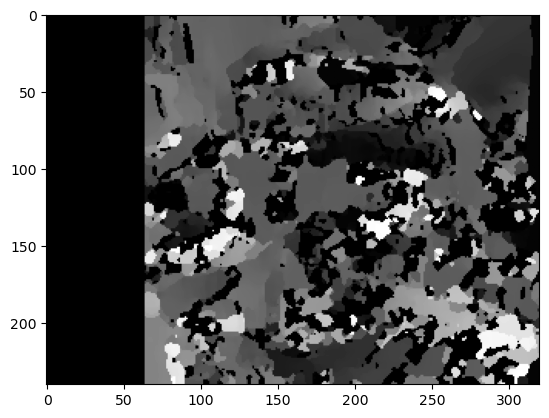

In [48]:
# W bibliotece OpenCV dostępne są dwie metody obliczenia map głębi: dopasowanie bloków
# (Block Matching) i SGM (Semi-Global Matching)
# Proszę samodzielnie, na podstawie dokumentacji, wyznaczyć mapę dysparycji
# dla jednego z obrazów z folderu example przed i po procesie kalibracji. Parametry poszczegól-
# nych funkcji proszę dobrać empirycznie, stosując się do ograniczeń. Wyświetl obraz oryginalny
# przed i po kalibracji oraz odpowiednie mapy dysparycji (SGM i BM).
# obraz example0.png składa się z dwóch obrazów: lewego i prawego

# Load images
img = cv2.imread("./data/example/example0.jpg")
img_size = img.shape
imgLeft = img[:, 0:int(img_size[1]/2), :]
imgRight = img[:, int(img_size[1]/2):img_size[1], :]

# Convert to grayscale
grayLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)

# Compute disparity map
# Block Matching
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(grayLeft, grayRight)

# Semi-Global Matching
stereo = cv2.StereoSGBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(grayLeft, grayRight)

# Display disparity map
plt.imshow(disparity, 'gray')
plt.show()


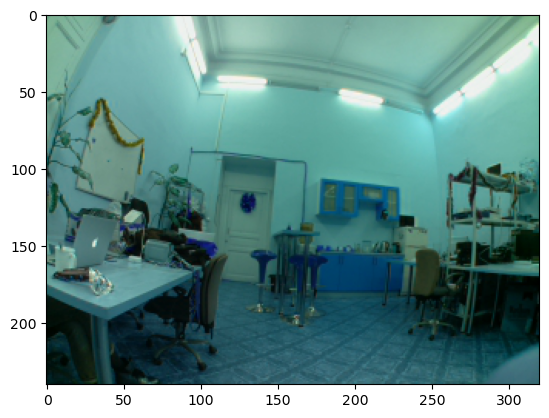

In [44]:
plt.imshow(imgRight)

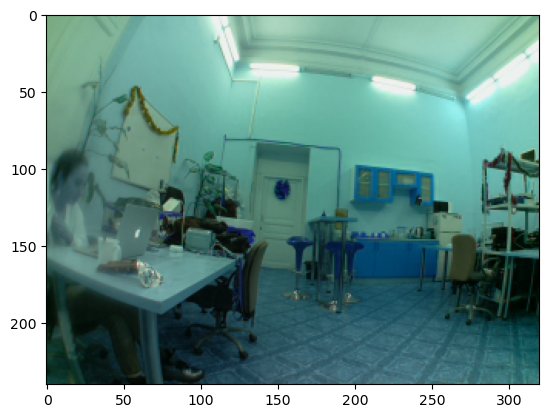

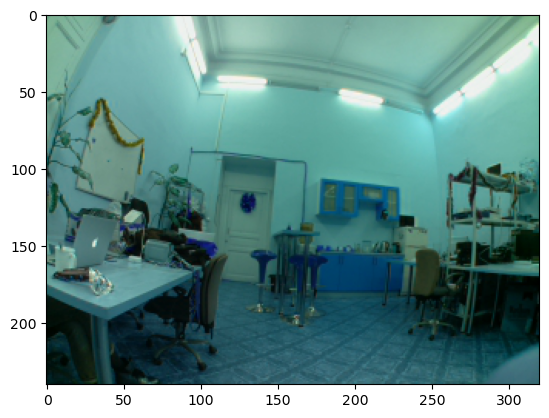

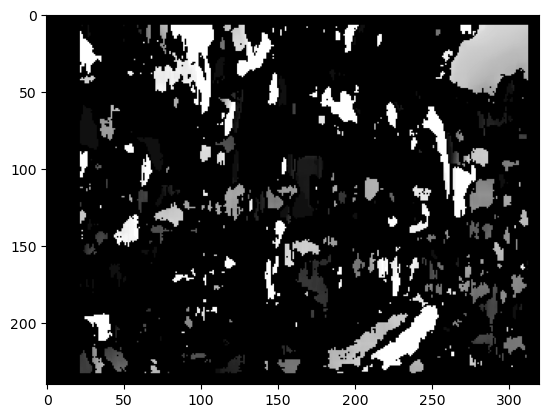

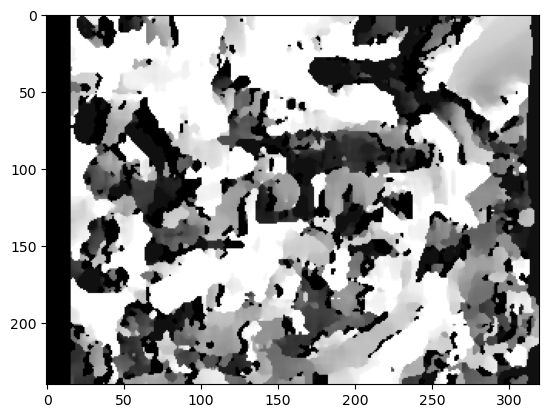

In [47]:
# Calculate the maps
# map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(K_left, D_left, leftRectification, leftProjection, img_size, cv2.CV_16SC2)

# Undistort images
# dst_L = cv2.remap(imgLeft, map1_left, map2_left, cv2.INTER_LINEAR)
# dst_R = cv2.remap(imgRight, map1_right, map2_right, cv2.INTER_LINEAR)

dst_L = imgLeft
dst_R = imgRight

plt.imshow(dst_L)
plt.show()

plt.imshow(dst_R)
plt.show()

# Convert to grayscale
grayLeft = cv2.cvtColor(dst_L, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(dst_R, cv2.COLOR_BGR2GRAY)

# Block Matching
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(grayLeft, grayRight)

plt.imshow(disparity, 'gray')
plt.show()

# Semi-Global Matching
stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(grayLeft, grayRight)

plt.imshow(disparity, 'gray')
plt.show()

In [ ]:
# Read the two images
img = cv2.imread("./data/example/example1.png")
img_size = img.shape
img1 = img[:, 0:int(img_size[1]/2), :]
img2 = img[:, int(img_size[1]/2):img_size[1], :]

In [58]:

# Read the two images
img = cv2.imread("./data/example/example1.png")
img_size = img.shape
img1 = img[:, 0:int(img_size[1]/2), :]
img2 = img[:, int(img_size[1]/2):img_size[1], :]

# Convert the images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Define block size and search window
block_size = 16  # Choose an appropriate block size
search_window = 64  # Choose an appropriate search window size

# Perform block matching
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(gray1, gray2)

# Normalize the disparity map for display
disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display the disparity map
cv2.imshow('Disparity Map', disparity_normalized)
cv2.waitKey(0)
cv2.destroyAllWindows()
